In [ ]:
# Cross-Lingual RSC Semantic Convergence Experiment (Phase 2C - Memory Reinforcement)
# Author: Erich Curtis
# Date: 2025-04-28

import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ------------------- 1. Vocabulary and Relations -------------------

def load_vocab_and_relations():
    english_vocab = [
        'dog', 'cat', 'horse', 'bird', 'fish', 'teacher', 'parent', 'child', 'friend', 'enemy',
        'chair', 'table', 'pen', 'phone', 'house', 'bridge', 'road', 'forest', 'river', 'mountain',
        'run', 'walk', 'swim', 'teach', 'learn', 'jump', 'help', 'hurt', 'love', 'eat',
        'happy', 'sad', 'angry', 'afraid', 'calm', 'excited', 'tired', 'safe',
        'earth', 'sun', 'water', 'ice', 'cloud', 'star', 'gravity'
    ]

    german_vocab = [
        'Hund', 'Katze', 'Pferd', 'Vogel', 'Fisch', 'Lehrer', 'Elternteil', 'Kind', 'Freund', 'Feind',
        'Stuhl', 'Tisch', 'Stift', 'Telefon', 'Haus', 'Brücke', 'Straße', 'Wald', 'Fluss', 'Berg',
        'laufen', 'gehen', 'schwimmen', 'lehren', 'lernen', 'springen', 'helfen', 'verletzen', 'lieben', 'essen',
        'glücklich', 'traurig', 'wütend', 'ängstlich', 'ruhig', 'aufgeregt', 'müde', 'sicher',
        'Erde', 'Sonne', 'Wasser', 'Eis', 'Wolke', 'Stern', 'Schwerkraft'
    ]

    eng_to_ger = dict(zip(english_vocab, german_vocab))

    simple_relations = [
        ('dog', 'chases', 'cat'),
        ('bird', 'flies', 'sky'),
        ('fish', 'swims', 'river'),
        ('teacher', 'teaches', 'child'),
        ('child', 'plays', 'dog')
    ]

    medium_relations = [
        ('dog', 'chases', 'cat', 'quickly'),
        ('teacher', 'teaches', 'child', 'at school'),
        ('river', 'flows', 'valley', 'during spring'),
        ('parent', 'guides', 'child', 'gently')
    ]

    complex_relations = [
        ('if', 'rain', 'then', 'ground becomes wet'),
        ('because', 'fire', 'burns', 'forest', 'animals flee'),
        ('although', 'sun', 'shines', 'clouds cover sky')
    ]

    ambiguous_relations = [
        ('bank', 'stores', 'money'),
        ('bank', 'stands', 'beside', 'river'),
        ('light', 'carries', 'little weight'),
        ('light', 'shines', 'sun')
    ]

    return english_vocab, german_vocab, eng_to_ger, simple_relations, medium_relations, complex_relations, ambiguous_relations

# ------------------- 2. Agent Initialization -------------------

def initialize_agents(english_vocab, german_vocab, eng_to_ger, seed=42):
    random.seed(seed)

    agent_a = {word: word for word in english_vocab}

    agent_b = {}
    for word in english_vocab:
        if random.random() < 0.8:
            agent_b[word] = eng_to_ger[word]
        else:
            agent_b[word] = random.choice(german_vocab)

    agent_c = {}
    for word in english_vocab:
        if random.random() < 0.3:
            agent_c[word] = eng_to_ger[word]
        else:
            agent_c[word] = random.choice(german_vocab)

    return agent_a, agent_b, agent_c

# ------------------- 3. Learning Phase (With Memory Reinforcement) -------------------

def run_learning(agent_a, agent_b, agent_c, simple_relations, medium_relations, complex_relations, ambiguous_relations,
                 total_frames=1500, batch_size=3, stability_threshold=3, memory_bias=0.5):
    proposals_log = []
    accuracy_simple = []
    accuracy_medium = []
    accuracy_complex = []
    accuracy_ambiguous = []

    stability_counters = {'simple': {}, 'medium': {}, 'complex': {}, 'ambiguous': {}}
    anchors = {'simple': set(), 'medium': set(), 'complex': set(), 'ambiguous': set()}

    all_ground_truth = set(simple_relations + medium_relations + complex_relations + ambiguous_relations)

    def validate_relation(*args):
        return args in all_ground_truth

    def try_validate(groundings, *words):
        mapped = [groundings.get(w, w) for w in words]
        return validate_relation(*mapped)

    for frame in tqdm(range(total_frames), desc="Learning Progress", unit="frame"):
        current_relations = []

        if frame < 500:
            current_relations = simple_relations
        elif frame < 1000:
            current_relations = simple_relations + medium_relations
        else:
            current_relations = simple_relations + medium_relations + complex_relations

        proposals = []
        for _ in range(batch_size):
            if (anchors['simple'] or anchors['medium'] or anchors['complex']) and random.random() < memory_bias:
                # Reinforce from memory
                memory_pool = list(anchors['simple'] | anchors['medium'] | anchors['complex'])
                proposals.append(random.choice(memory_pool))
            else:
                # Random proposal
                proposals.append(random.choice(current_relations))

        # Inject ambiguous relation every 100 frames
        if frame % 100 == 0 and ambiguous_relations:
            proposals.append(random.choice(ambiguous_relations))

        success_simple, success_medium, success_complex, success_ambiguous = 0, 0, 0, 0

        for proposal in proposals:
            if try_validate(agent_b, *proposal):
                category = categorize_relation(proposal, simple_relations, medium_relations, complex_relations, ambiguous_relations)
                stability_counters[category][proposal] = stability_counters[category].get(proposal, 0) + 1
                if stability_counters[category][proposal] == stability_threshold:
                    anchors[category].add(proposal)
                proposals_log.append(f"Frame {frame}: {proposal} → ACCEPTED (A↔B) [{category}]")
                if category == 'simple':
                    success_simple += 1
                elif category == 'medium':
                    success_medium += 1
                elif category == 'complex':
                    success_complex += 1
                elif category == 'ambiguous':
                    success_ambiguous += 1
            else:
                proposals_log.append(f"Frame {frame}: {proposal} → REJECTED (A↔B)")

        accuracy_simple.append(success_simple / batch_size)
        accuracy_medium.append(success_medium / batch_size)
        accuracy_complex.append(success_complex / batch_size)
        accuracy_ambiguous.append(success_ambiguous / batch_size)

        # Drift agent C
        if frame % 25 == 0 and frame != 0:
            for word in random.sample(list(agent_c.keys()), 5):
                agent_c[word] = random.choice(list(agent_c.keys()))

    return proposals_log, accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous

def categorize_relation(relation, simple, medium, complex_, ambiguous):
    if relation in simple:
        return 'simple'
    if relation in medium:
        return 'medium'
    if relation in complex_:
        return 'complex'
    if relation in ambiguous:
        return 'ambiguous'
    return 'unknown'

# ------------------- 4. Plotting -------------------

def plot_accuracies(accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, total_frames):
    frames = range(total_frames)
    plt.figure(figsize=(14, 7))
    plt.plot(frames, moving_average(accuracy_simple), label="Simple Relations", linewidth=2)
    plt.plot(frames, moving_average(accuracy_medium), label="Medium Relations", linewidth=2)
    plt.plot(frames, moving_average(accuracy_complex), label="Complex Relations", linewidth=2)
    plt.plot(frames, moving_average(accuracy_ambiguous), label="Ambiguous Relations", linewidth=2)
    plt.xlabel('Learning Frame', fontsize=14)
    plt.ylabel('Moving Average Accuracy', fontsize=14)
    plt.title('Cross-Lingual RSC Convergence Accuracy with Memory Reinforcement', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def moving_average(data, window_size=25):
    if len(data) < window_size:
        return np.array(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# ------------------- 5. Main -------------------

def main():
    (english_vocab, german_vocab, eng_to_ger,
     simple_relations, medium_relations, complex_relations, ambiguous_relations) = load_vocab_and_relations()
    
    agent_a, agent_b, agent_c = initialize_agents(english_vocab, german_vocab, eng_to_ger)

    (proposals_log, accuracy_simple, accuracy_medium,
     accuracy_complex, accuracy_ambiguous) = run_learning(agent_a, agent_b, agent_c,
                                                           simple_relations, medium_relations,
                                                           complex_relations, ambiguous_relations)

    with open('phase2C_memory_reinforcement_log.txt', 'w', encoding='utf-8') as f:
        for line in proposals_log:
            f.write(line + '\n')

    plot_accuracies(accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, total_frames=1500)

if __name__ == "__main__":
    main()

# Phase 2D Language with math operators

In [ ]:
# Cross-Lingual RSC Semantic Convergence Experiment (Phase 2D - Expanded Language + Arithmetic)
# Author: Erich Curtis
# Date: 2025-04-28

import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ------------------- 1. Vocabulary and Relations -------------------

def load_vocab_and_relations():
    english_vocab = [
        # Language vocab
        'dog', 'cat', 'horse', 'bird', 'fish', 'teacher', 'parent', 'child', 'friend', 'enemy',
        'chair', 'table', 'pen', 'phone', 'house', 'bridge', 'road', 'forest', 'river', 'mountain',
        'run', 'walk', 'swim', 'teach', 'learn', 'jump', 'help', 'hurt', 'love', 'eat',
        'happy', 'sad', 'angry', 'afraid', 'calm', 'excited', 'tired', 'safe',
        'earth', 'sun', 'water', 'ice', 'cloud', 'star', 'gravity',
        # Arithmetic vocab
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'plus', 'minus', 'times', 'divided_by', 'equals', 'greater_than', 'less_than'
    ]

    german_vocab = [
        'Hund', 'Katze', 'Pferd', 'Vogel', 'Fisch', 'Lehrer', 'Elternteil', 'Kind', 'Freund', 'Feind',
        'Stuhl', 'Tisch', 'Stift', 'Telefon', 'Haus', 'Brücke', 'Straße', 'Wald', 'Fluss', 'Berg',
        'laufen', 'gehen', 'schwimmen', 'lehren', 'lernen', 'springen', 'helfen', 'verletzen', 'lieben', 'essen',
        'glücklich', 'traurig', 'wütend', 'ängstlich', 'ruhig', 'aufgeregt', 'müde', 'sicher',
        'Erde', 'Sonne', 'Wasser', 'Eis', 'Wolke', 'Stern', 'Schwerkraft'
    ]

    eng_to_ger = dict(zip(english_vocab[:len(german_vocab)], german_vocab))  # only language vocab mapped, math stays English

    # Relations
    simple_relations = [
        ('dog', 'chases', 'cat'),
        ('bird', 'flies', 'sky'),
        ('fish', 'swims', 'river'),
        ('teacher', 'teaches', 'child'),
        ('child', 'plays', 'dog'),
        ('friend', 'helps', 'friend'),
        ('parent', 'guides', 'child'),
        ('sun', 'shines', 'earth'),
        ('cloud', 'covers', 'sun'),
        ('river', 'flows', 'valley')
    ]

    medium_relations = [
        ('dog', 'chases', 'cat', 'quickly'),
        ('teacher', 'teaches', 'child', 'at school'),
        ('river', 'flows', 'valley', 'during spring'),
        ('parent', 'guides', 'child', 'gently'),
        ('bird', 'flies', 'over', 'mountain'),
        ('child', 'learns', 'lesson', 'fast'),
        ('fish', 'swims', 'under', 'bridge'),
        ('earth', 'rotates', 'around', 'sun'),
        ('teacher', 'corrects', 'homework', 'patiently'),
        ('friend', 'comforts', 'friend', 'after loss')
    ]

    complex_relations = [
        ('if', 'rain', 'then', 'ground becomes wet'),
        ('because', 'fire', 'burns', 'forest', 'animals flee'),
        ('although', 'sun', 'shines', 'clouds cover sky'),
        ('if', 'parent', 'guides', 'child', 'then', 'child', 'learns', 'faster'),
        ('if', 'river', 'floods', 'then', 'village', 'is', 'damaged')
    ]

    ambiguous_relations = [
        ('bank', 'stores', 'money'),
        ('bank', 'stands', 'beside', 'river'),
        ('light', 'carries', 'little weight'),
        ('light', 'shines', 'brightly'),
        ('spring', 'comes', 'after', 'winter'),
        ('spring', 'bubbles', 'from', 'ground')
    ]

    arithmetic_relations = [
        ('2', 'plus', '3', 'equals', '5'),
        ('4', 'minus', '1', 'equals', '3'),
        ('2', 'times', '2', 'equals', '4'),
        ('8', 'divided_by', '2', 'equals', '4'),
        ('3', 'greater_than', '2'),
        ('2', 'less_than', '5'),
        ('1', 'plus', '1', 'equals', '2'),
        ('5', 'minus', '3', 'equals', '2'),
        ('9', 'divided_by', '3', 'equals', '3'),
        ('6', 'times', '1', 'equals', '6')
    ]

    return english_vocab, german_vocab, eng_to_ger, simple_relations, medium_relations, complex_relations, ambiguous_relations, arithmetic_relations

# ------------------- 2. Agent Initialization -------------------

def initialize_agents(english_vocab, german_vocab, eng_to_ger, seed=42):
    random.seed(seed)

    agent_a = {word: word for word in english_vocab}

    agent_b = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_b[word] = eng_to_ger[word] if random.random() < 0.8 else random.choice(german_vocab)
        else:
            agent_b[word] = word  # math terms stay English

    agent_c = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_c[word] = eng_to_ger[word] if random.random() < 0.3 else random.choice(german_vocab)
        else:
            agent_c[word] = word

    return agent_a, agent_b, agent_c

# ------------------- 3. Learning Phase -------------------

def run_learning(agent_a, agent_b, agent_c, simple_relations, medium_relations, complex_relations, ambiguous_relations, arithmetic_relations,
                 total_frames=2000, batch_size=5, stability_threshold=3, memory_bias=0.5):
    proposals_log = []
    accuracy_simple = []
    accuracy_medium = []
    accuracy_complex = []
    accuracy_ambiguous = []
    accuracy_arithmetic = []

    stability_counters = {'simple': {}, 'medium': {}, 'complex': {}, 'ambiguous': {}, 'arithmetic': {}}
    anchors = {'simple': set(), 'medium': set(), 'complex': set(), 'ambiguous': set(), 'arithmetic': set()}

    all_ground_truth = set(simple_relations + medium_relations + complex_relations + ambiguous_relations + arithmetic_relations)

    def validate_relation(*args):
        return args in all_ground_truth

    def try_validate(groundings, *words):
        mapped = [groundings.get(w, w) for w in words]
        return validate_relation(*mapped)

    for frame in tqdm(range(total_frames), desc="Learning Progress", unit="frame"):
        current_relations = simple_relations + medium_relations
        if frame > 750:
            current_relations += complex_relations
        if frame > 1500:
            current_relations += ambiguous_relations + arithmetic_relations

        proposals = []
        for _ in range(batch_size):
            if (anchors['simple'] | anchors['medium'] | anchors['complex'] | anchors['arithmetic']) and random.random() < memory_bias:
                memory_pool = list(anchors['simple'] | anchors['medium'] | anchors['complex'] | anchors['arithmetic'])
                proposals.append(random.choice(memory_pool))
            else:
                proposals.append(random.choice(current_relations))

        success_simple, success_medium, success_complex, success_ambiguous, success_arithmetic = 0, 0, 0, 0, 0

        for proposal in proposals:
            if try_validate(agent_b, *proposal):
                category = categorize_relation(proposal, simple_relations, medium_relations, complex_relations, ambiguous_relations, arithmetic_relations)
                stability_counters[category][proposal] = stability_counters[category].get(proposal, 0) + 1
                if stability_counters[category][proposal] == stability_threshold:
                    anchors[category].add(proposal)
                proposals_log.append(f"Frame {frame}: {proposal} → ACCEPTED (A↔B) [{category}]")
                if category == 'simple':
                    success_simple += 1
                elif category == 'medium':
                    success_medium += 1
                elif category == 'complex':
                    success_complex += 1
                elif category == 'ambiguous':
                    success_ambiguous += 1
                elif category == 'arithmetic':
                    success_arithmetic += 1
            else:
                proposals_log.append(f"Frame {frame}: {proposal} → REJECTED (A↔B)")

        accuracy_simple.append(success_simple / batch_size)
        accuracy_medium.append(success_medium / batch_size)
        accuracy_complex.append(success_complex / batch_size)
        accuracy_ambiguous.append(success_ambiguous / batch_size)
        accuracy_arithmetic.append(success_arithmetic / batch_size)

        if frame % 25 == 0 and frame != 0:
            for word in random.sample(list(agent_c.keys()), 5):
                agent_c[word] = random.choice(list(agent_c.keys()))

    return proposals_log, accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, accuracy_arithmetic

def categorize_relation(relation, simple, medium, complex_, ambiguous, arithmetic):
    if relation in simple:
        return 'simple'
    if relation in medium:
        return 'medium'
    if relation in complex_:
        return 'complex'
    if relation in ambiguous:
        return 'ambiguous'
    if relation in arithmetic:
        return 'arithmetic'
    return 'unknown'

# ------------------- 4. Plotting -------------------

def plot_accuracies(accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, accuracy_arithmetic, total_frames):
    frames = range(total_frames)
    plt.figure(figsize=(14, 8))
    plt.plot(frames, moving_average(accuracy_simple), label="Simple", linewidth=2)
    plt.plot(frames, moving_average(accuracy_medium), label="Medium", linewidth=2)
    plt.plot(frames, moving_average(accuracy_complex), label="Complex", linewidth=2)
    plt.plot(frames, moving_average(accuracy_ambiguous), label="Ambiguous", linewidth=2)
    plt.plot(frames, moving_average(accuracy_arithmetic), label="Arithmetic", linewidth=2)
    plt.xlabel('Learning Frame', fontsize=14)
    plt.ylabel('Moving Average Accuracy', fontsize=14)
    plt.title('Cross-Lingual RSC Convergence (Language + Math)', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def moving_average(data, window_size=25):
    if len(data) < window_size:
        return np.array(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# ------------------- 5. Main -------------------

def main():
    (english_vocab, german_vocab, eng_to_ger,
     simple_relations, medium_relations, complex_relations, ambiguous_relations, arithmetic_relations) = load_vocab_and_relations()
    
    agent_a, agent_b, agent_c = initialize_agents(english_vocab, german_vocab, eng_to_ger)

    (proposals_log, accuracy_simple, accuracy_medium,
     accuracy_complex, accuracy_ambiguous, accuracy_arithmetic) = run_learning(agent_a, agent_b, agent_c,
                                                                                simple_relations, medium_relations,
                                                                                complex_relations, ambiguous_relations,
                                                                                arithmetic_relations)

    with open('phase2D_language_math_log.txt', 'w', encoding='utf-8') as f:
        for line in proposals_log:
            f.write(line + '\n')

    plot_accuracies(accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, accuracy_arithmetic, total_frames=2000)

if __name__ == "__main__":
    main()


In [ ]:
# Cross-Lingual RSC Semantic Convergence Experiment (Phase 2E - Language + Arithmetic + Word-Number Relations)
# Author: Erich Curtis
# Date: 2025-04-28

import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ------------------- 1. Vocabulary and Relations -------------------

def load_vocab_and_relations():
    english_vocab = [
        'dog', 'cat', 'horse', 'bird', 'fish', 'teacher', 'parent', 'child', 'friend', 'enemy',
        'chair', 'table', 'pen', 'phone', 'house', 'bridge', 'road', 'forest', 'river', 'mountain',
        'run', 'walk', 'swim', 'teach', 'learn', 'jump', 'help', 'hurt', 'love', 'eat',
        'happy', 'sad', 'angry', 'afraid', 'calm', 'excited', 'tired', 'safe',
        'earth', 'sun', 'water', 'ice', 'cloud', 'star', 'gravity', 'person', 'car', 'school',
        # Arithmetic vocab
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '20', '30',
        'plus', 'minus', 'times', 'divided_by', 'equals', 'greater_than', 'less_than'
    ]

    german_vocab = [
        'Hund', 'Katze', 'Pferd', 'Vogel', 'Fisch', 'Lehrer', 'Elternteil', 'Kind', 'Freund', 'Feind',
        'Stuhl', 'Tisch', 'Stift', 'Telefon', 'Haus', 'Brücke', 'Straße', 'Wald', 'Fluss', 'Berg',
        'laufen', 'gehen', 'schwimmen', 'lehren', 'lernen', 'springen', 'helfen', 'verletzen', 'lieben', 'essen',
        'glücklich', 'traurig', 'wütend', 'ängstlich', 'ruhig', 'aufgeregt', 'müde', 'sicher',
        'Erde', 'Sonne', 'Wasser', 'Eis', 'Wolke', 'Stern', 'Schwerkraft', 'Person', 'Auto', 'Schule'
    ]

    eng_to_ger = dict(zip(english_vocab[:len(german_vocab)], german_vocab))  # math terms stay English

    simple_relations = [
        ('dog', 'chases', 'cat'),
        ('bird', 'flies', 'sky'),
        ('fish', 'swims', 'river'),
        ('teacher', 'teaches', 'child'),
        ('child', 'plays', 'dog'),
        ('friend', 'helps', 'friend'),
        ('parent', 'guides', 'child'),
        ('sun', 'shines', 'earth'),
        ('cloud', 'covers', 'sun'),
        ('river', 'flows', 'valley')
    ]

    medium_relations = [
        ('dog', 'chases', 'cat', 'quickly'),
        ('teacher', 'teaches', 'child', 'at school'),
        ('river', 'flows', 'valley', 'during spring'),
        ('parent', 'guides', 'child', 'gently'),
        ('bird', 'flies', 'over', 'mountain'),
        ('child', 'learns', 'lesson', 'fast'),
        ('fish', 'swims', 'under', 'bridge'),
        ('earth', 'rotates', 'around', 'sun'),
        ('teacher', 'corrects', 'homework', 'patiently'),
        ('friend', 'comforts', 'friend', 'after loss')
    ]

    complex_relations = [
        ('if', 'rain', 'then', 'ground becomes wet'),
        ('because', 'fire', 'burns', 'forest', 'animals flee'),
        ('although', 'sun', 'shines', 'clouds cover sky'),
        ('if', 'parent', 'guides', 'child', 'then', 'child', 'learns', 'faster'),
        ('if', 'river', 'floods', 'then', 'village', 'is', 'damaged')
    ]

    ambiguous_relations = [
        ('bank', 'stores', 'money'),
        ('bank', 'stands', 'beside', 'river'),
        ('light', 'carries', 'little weight'),
        ('light', 'shines', 'brightly'),
        ('spring', 'comes', 'after', 'winter'),
        ('spring', 'bubbles', 'from', 'ground')
    ]

    arithmetic_relations = [
        ('2', 'plus', '3', 'equals', '5'),
        ('4', 'minus', '1', 'equals', '3'),
        ('2', 'times', '2', 'equals', '4'),
        ('8', 'divided_by', '2', 'equals', '4'),
        ('3', 'greater_than', '2'),
        ('2', 'less_than', '5'),
        ('1', 'plus', '1', 'equals', '2'),
        ('5', 'minus', '3', 'equals', '2'),
        ('9', 'divided_by', '3', 'equals', '3'),
        ('6', 'times', '1', 'equals', '6')
    ]

    word_number_relations = [
        ('dog', 'has', '4', 'legs'),
        ('bird', 'has', '2', 'wings'),
        ('person', 'has', '2', 'eyes'),
        ('car', 'has', '4', 'wheels'),
        ('table', 'has', '4', 'legs'),
        ('fish', 'has', '0', 'legs'),
        ('school', 'has', '20', 'students'),
        ('teacher', 'teaches', '30', 'students'),
        ('parent', 'has', '2', 'children'),
        ('star', 'shines', 'in', '1', 'sky')
    ]

    return (english_vocab, german_vocab, eng_to_ger, simple_relations, medium_relations,
            complex_relations, ambiguous_relations, arithmetic_relations, word_number_relations)

# ------------------- 2. Agent Initialization -------------------

def initialize_agents(english_vocab, german_vocab, eng_to_ger, seed=42):
    random.seed(seed)

    agent_a = {word: word for word in english_vocab}

    agent_b = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_b[word] = eng_to_ger[word] if random.random() < 0.8 else random.choice(german_vocab)
        else:
            agent_b[word] = word  # math terms stay English

    agent_c = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_c[word] = eng_to_ger[word] if random.random() < 0.3 else random.choice(german_vocab)
        else:
            agent_c[word] = word

    return agent_a, agent_b, agent_c

# ------------------- 3. Learning Phase -------------------

def run_learning(agent_a, agent_b, agent_c, simple_relations, medium_relations, complex_relations, ambiguous_relations,
                 arithmetic_relations, word_number_relations, total_frames=2000, batch_size=5, stability_threshold=3, memory_bias=0.5):

    proposals_log = []
    accuracy_simple = []
    accuracy_medium = []
    accuracy_complex = []
    accuracy_ambiguous = []
    accuracy_arithmetic = []
    accuracy_word_number = []

    stability_counters = {'simple': {}, 'medium': {}, 'complex': {}, 'ambiguous': {}, 'arithmetic': {}, 'word_number': {}}
    anchors = {'simple': set(), 'medium': set(), 'complex': set(), 'ambiguous': set(), 'arithmetic': set(), 'word_number': set()}

    all_ground_truth = set(simple_relations + medium_relations + complex_relations + ambiguous_relations + arithmetic_relations + word_number_relations)

    def validate_relation(*args):
        return args in all_ground_truth

    def try_validate(groundings, *words):
        mapped = [groundings.get(w, w) for w in words]
        return validate_relation(*mapped)

    for frame in tqdm(range(total_frames), desc="Learning Progress", unit="frame"):
        current_relations = simple_relations + medium_relations
        if frame > 750:
            current_relations += complex_relations
        if frame > 1500:
            current_relations += ambiguous_relations + arithmetic_relations + word_number_relations

        proposals = []
        for _ in range(batch_size):
            if (any(anchors.values())) and random.random() < memory_bias:
                memory_pool = list(set().union(*anchors.values()))
                proposals.append(random.choice(memory_pool))
            else:
                proposals.append(random.choice(current_relations))

        success = {'simple': 0, 'medium': 0, 'complex': 0, 'ambiguous': 0, 'arithmetic': 0, 'word_number': 0}

        for proposal in proposals:
            if try_validate(agent_b, *proposal):
                category = categorize_relation(proposal, simple_relations, medium_relations, complex_relations, ambiguous_relations, arithmetic_relations, word_number_relations)
                stability_counters[category][proposal] = stability_counters[category].get(proposal, 0) + 1
                if stability_counters[category][proposal] == stability_threshold:
                    anchors[category].add(proposal)
                success[category] += 1
                proposals_log.append(f"Frame {frame}: {proposal} → ACCEPTED (A↔B) [{category}]")
            else:
                proposals_log.append(f"Frame {frame}: {proposal} → REJECTED (A↔B)")

        accuracy_simple.append(success['simple'] / batch_size)
        accuracy_medium.append(success['medium'] / batch_size)
        accuracy_complex.append(success['complex'] / batch_size)
        accuracy_ambiguous.append(success['ambiguous'] / batch_size)
        accuracy_arithmetic.append(success['arithmetic'] / batch_size)
        accuracy_word_number.append(success['word_number'] / batch_size)

        if frame % 25 == 0 and frame != 0:
            for word in random.sample(list(agent_c.keys()), 5):
                agent_c[word] = random.choice(list(agent_c.keys()))

    return proposals_log, accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, accuracy_arithmetic, accuracy_word_number

def categorize_relation(relation, simple, medium, complex_, ambiguous, arithmetic, word_number):
    if relation in simple:
        return 'simple'
    if relation in medium:
        return 'medium'
    if relation in complex_:
        return 'complex'
    if relation in ambiguous:
        return 'ambiguous'
    if relation in arithmetic:
        return 'arithmetic'
    if relation in word_number:
        return 'word_number'
    return 'unknown'

# ------------------- 4. Plotting -------------------

def plot_accuracies(accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, accuracy_arithmetic, accuracy_word_number, total_frames):
    frames = range(total_frames)
    plt.figure(figsize=(14, 8))
    plt.plot(frames, moving_average(accuracy_simple), label="Simple", linewidth=2)
    plt.plot(frames, moving_average(accuracy_medium), label="Medium", linewidth=2)
    plt.plot(frames, moving_average(accuracy_complex), label="Complex", linewidth=2)
    plt.plot(frames, moving_average(accuracy_ambiguous), label="Ambiguous", linewidth=2)
    plt.plot(frames, moving_average(accuracy_arithmetic), label="Arithmetic", linewidth=2)
    plt.plot(frames, moving_average(accuracy_word_number), label="Word-Number", linewidth=2)
    plt.xlabel('Learning Frame', fontsize=14)
    plt.ylabel('Moving Average Accuracy', fontsize=14)
    plt.title('Cross-Lingual RSC Convergence (Expanded Language + Arithmetic + Word-Number)', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def moving_average(data, window_size=25):
    if len(data) < window_size:
        return np.array(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# ------------------- 5. Main -------------------

def main():
    (english_vocab, german_vocab, eng_to_ger,
     simple_relations, medium_relations, complex_relations,
     ambiguous_relations, arithmetic_relations, word_number_relations) = load_vocab_and_relations()
    
    agent_a, agent_b, agent_c = initialize_agents(english_vocab, german_vocab, eng_to_ger)

    (proposals_log, accuracy_simple, accuracy_medium,
     accuracy_complex, accuracy_ambiguous, accuracy_arithmetic,
     accuracy_word_number) = run_learning(agent_a, agent_b, agent_c,
                                          simple_relations, medium_relations,
                                          complex_relations, ambiguous_relations,
                                          arithmetic_relations, word_number_relations)

    with open('phase2E_language_math_wordnumber_log.txt', 'w', encoding='utf-8') as f:
        for line in proposals_log:
            f.write(line + '\n')

    plot_accuracies(accuracy_simple, accuracy_medium, accuracy_complex,
                    accuracy_ambiguous, accuracy_arithmetic, accuracy_word_number, total_frames=2000)

if __name__ == "__main__":
    main()

# Phase 2F

In [ ]:
# Cross-Lingual RSC Semantic Convergence Experiment (Phase 2F - Curriculum-Gated Semantic Anchoring)
# Author: Erich Curtis
# Date: 2025-04-28

import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# ------------------- 1. Vocabulary and Relations -------------------

def load_vocab_and_relations():
    english_vocab = [
        'dog', 'cat', 'horse', 'bird', 'fish', 'teacher', 'parent', 'child', 'friend', 'enemy',
        'chair', 'table', 'pen', 'phone', 'house', 'bridge', 'road', 'forest', 'river', 'mountain',
        'run', 'walk', 'swim', 'teach', 'learn', 'jump', 'help', 'hurt', 'love', 'eat',
        'happy', 'sad', 'angry', 'afraid', 'calm', 'excited', 'tired', 'safe',
        'earth', 'sun', 'water', 'ice', 'cloud', 'star', 'gravity', 'person', 'car', 'school',
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '20', '30',
        'plus', 'minus', 'times', 'divided_by', 'equals', 'greater_than', 'less_than'
    ]

    german_vocab = [
        'Hund', 'Katze', 'Pferd', 'Vogel', 'Fisch', 'Lehrer', 'Elternteil', 'Kind', 'Freund', 'Feind',
        'Stuhl', 'Tisch', 'Stift', 'Telefon', 'Haus', 'Brücke', 'Straße', 'Wald', 'Fluss', 'Berg',
        'laufen', 'gehen', 'schwimmen', 'lehren', 'lernen', 'springen', 'helfen', 'verletzen', 'lieben', 'essen',
        'glücklich', 'traurig', 'wütend', 'ängstlich', 'ruhig', 'aufgeregt', 'müde', 'sicher',
        'Erde', 'Sonne', 'Wasser', 'Eis', 'Wolke', 'Stern', 'Schwerkraft', 'Person', 'Auto', 'Schule'
    ]

    eng_to_ger = dict(zip(english_vocab[:len(german_vocab)], german_vocab))

    simple_relations = [
        ('dog', 'chases', 'cat'),
        ('bird', 'flies', 'sky'),
        ('fish', 'swims', 'river'),
        ('teacher', 'teaches', 'child'),
        ('child', 'plays', 'dog'),
        ('friend', 'helps', 'friend'),
        ('parent', 'guides', 'child'),
        ('sun', 'shines', 'earth'),
        ('cloud', 'covers', 'sun'),
        ('river', 'flows', 'valley')
    ]

    medium_relations = [
        ('dog', 'chases', 'cat', 'quickly'),
        ('teacher', 'teaches', 'child', 'at school'),
        ('river', 'flows', 'valley', 'during spring'),
        ('parent', 'guides', 'child', 'gently'),
        ('bird', 'flies', 'over', 'mountain'),
        ('child', 'learns', 'lesson', 'fast'),
        ('fish', 'swims', 'under', 'bridge'),
        ('earth', 'rotates', 'around', 'sun'),
        ('teacher', 'corrects', 'homework', 'patiently'),
        ('friend', 'comforts', 'friend', 'after loss')
    ]

    complex_relations = [
        ('if', 'rain', 'then', 'ground becomes wet'),
        ('because', 'fire', 'burns', 'forest', 'animals flee'),
        ('although', 'sun', 'shines', 'clouds cover sky'),
        ('if', 'parent', 'guides', 'child', 'then', 'child', 'learns', 'faster'),
        ('if', 'river', 'floods', 'then', 'village', 'is', 'damaged')
    ]

    ambiguous_relations = [
        ('bank', 'stores', 'money'),
        ('bank', 'stands', 'beside', 'river'),
        ('light', 'carries', 'little weight'),
        ('light', 'shines', 'brightly'),
        ('spring', 'comes', 'after', 'winter'),
        ('spring', 'bubbles', 'from', 'ground')
    ]

    arithmetic_relations = [
        ('2', 'plus', '3', 'equals', '5'),
        ('4', 'minus', '1', 'equals', '3'),
        ('2', 'times', '2', 'equals', '4'),
        ('8', 'divided_by', '2', 'equals', '4'),
        ('3', 'greater_than', '2'),
        ('2', 'less_than', '5')
    ]

    word_number_relations = [
        ('dog', 'has', '4', 'legs'),
        ('bird', 'has', '2', 'wings'),
        ('person', 'has', '2', 'eyes'),
        ('car', 'has', '4', 'wheels'),
        ('table', 'has', '4', 'legs')
    ]

    return (english_vocab, german_vocab, eng_to_ger, simple_relations, medium_relations,
            complex_relations, ambiguous_relations, arithmetic_relations, word_number_relations)

# ------------------- 2. Agent Initialization -------------------

def initialize_agents(english_vocab, german_vocab, eng_to_ger, seed=42):
    random.seed(seed)

    agent_a = {word: word for word in english_vocab}

    agent_b = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_b[word] = eng_to_ger[word] if random.random() < 0.8 else random.choice(german_vocab)
        else:
            agent_b[word] = word  # math terms stay English

    agent_c = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_c[word] = eng_to_ger[word] if random.random() < 0.3 else random.choice(german_vocab)
        else:
            agent_c[word] = word

    return agent_a, agent_b, agent_c

In [ ]:
def run_learning(agent_a, agent_b, agent_c, simple_relations, medium_relations, complex_relations,
                 ambiguous_relations, arithmetic_relations, word_number_relations,
                 total_frames=2500, batch_size=5, stability_threshold=3, memory_bias=0.5, gate_threshold=0.7):

    proposals_log = []
    accuracy_simple, accuracy_medium, accuracy_complex = [], [], []
    accuracy_ambiguous, accuracy_arithmetic, accuracy_word_number = [], [], []

    stability_counters = {cat: {} for cat in ['simple', 'medium', 'complex', 'ambiguous', 'arithmetic', 'word_number']}
    anchors = {cat: set() for cat in ['simple', 'medium', 'complex', 'ambiguous', 'arithmetic', 'word_number']}

    all_ground_truth = set(simple_relations + medium_relations + complex_relations +
                           ambiguous_relations + arithmetic_relations + word_number_relations)

    unlocked_medium = False
    unlocked_complex = False
    unlocked_full = False

    def validate_relation(*args):
        return args in all_ground_truth

    def try_validate(groundings, *words):
        mapped = [groundings.get(w, w) for w in words]
        return validate_relation(*mapped)

    for frame in tqdm(range(total_frames), desc="Learning Progress", unit="frame"):
        
        # Curriculum Gating: Unlock new relation types
        simple_accuracy = np.mean(accuracy_simple[-50:]) if len(accuracy_simple) > 50 else 0
        medium_accuracy = np.mean(accuracy_medium[-50:]) if len(accuracy_medium) > 50 else 0
        complex_accuracy = np.mean(accuracy_complex[-50:]) if len(accuracy_complex) > 50 else 0

        allowed_relations = simple_relations

        if simple_accuracy >= gate_threshold:
            unlocked_medium = True
        if unlocked_medium:
            allowed_relations += medium_relations

        if medium_accuracy >= gate_threshold:
            unlocked_complex = True
        if unlocked_complex:
            allowed_relations += complex_relations

        if complex_accuracy >= gate_threshold:
            unlocked_full = True
        if unlocked_full:
            allowed_relations += ambiguous_relations + arithmetic_relations + word_number_relations

        # Memory sampling
        proposals = []
        for _ in range(batch_size):
            if (any(anchors.values())) and random.random() < memory_bias:
                memory_pool = list(set().union(*anchors.values()))
                proposals.append(random.choice(memory_pool))
            else:
                proposals.append(random.choice(allowed_relations))

        success = {cat: 0 for cat in ['simple', 'medium', 'complex', 'ambiguous', 'arithmetic', 'word_number']}

        for proposal in proposals:
            if try_validate(agent_b, *proposal):
                category = categorize_relation(proposal, simple_relations, medium_relations, complex_relations,
                                               ambiguous_relations, arithmetic_relations, word_number_relations)
                stability_counters[category][proposal] = stability_counters[category].get(proposal, 0) + 1
                if stability_counters[category][proposal] == stability_threshold:
                    anchors[category].add(proposal)
                success[category] += 1
                proposals_log.append(f"Frame {frame}: {proposal} → ACCEPTED (A↔B) [{category}]")
            else:
                proposals_log.append(f"Frame {frame}: {proposal} → REJECTED (A↔B)")

        accuracy_simple.append(success['simple'] / batch_size)
        accuracy_medium.append(success['medium'] / batch_size)
        accuracy_complex.append(success['complex'] / batch_size)
        accuracy_ambiguous.append(success['ambiguous'] / batch_size)
        accuracy_arithmetic.append(success['arithmetic'] / batch_size)
        accuracy_word_number.append(success['word_number'] / batch_size)

        # Drift agent C
        if frame % 25 == 0 and frame != 0:
            for word in random.sample(list(agent_c.keys()), 5):
                agent_c[word] = random.choice(list(agent_c.keys()))

    return proposals_log, accuracy_simple, accuracy_medium, accuracy_complex, accuracy_ambiguous, accuracy_arithmetic, accuracy_word_number

In [ ]:
# if __name__ == "__main__":
#     main()

# Phase 2G

In [37]:
# --- Phase 2G
# Agent Initialization and Curriculum Gating Setup

def initialize_agents(english_vocab, german_vocab, eng_to_ger, seed=42):
    random.seed(seed)

    agent_a = {word: word for word in english_vocab}

    agent_b = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_b[word] = eng_to_ger[word] if random.random() < 0.8 else random.choice(german_vocab)
        else:
            agent_b[word] = word  # Numbers and math terms stay in English

    agent_c = {}
    for word in english_vocab:
        if word in eng_to_ger:
            agent_c[word] = eng_to_ger[word] if random.random() < 0.3 else random.choice(german_vocab)
        else:
            agent_c[word] = word

    return agent_a, agent_b, agent_c

def categorize_relation(relation, simple, medium, complex_, composite, complex_composite, ambiguous, arithmetic, word_number):
    if relation in simple:
        return 'simple'
    if relation in medium:
        return 'medium'
    if relation in complex_:
        return 'complex'
    if relation in composite:
        return 'composite'
    if relation in complex_composite:
        return 'complex_composite'
    if relation in ambiguous:
        return 'ambiguous'
    if relation in arithmetic:
        return 'arithmetic'
    if relation in word_number:
        return 'word_number'
    return 'unknown'


# --- Phase 2G: Part 3 of 4 ---
# Learning Loop with Memory, Drift, and Semantic Gating

import numpy as np
from tqdm import tqdm

def run_learning(agent_a, agent_b, agent_c,
                 simple_relations, word_number_relations, medium_relations,
                 complex_relations, composite_relations, complex_composite_relations,
                 ambiguous_relations, arithmetic_relations,
                 total_frames=2500, batch_size=5, stability_threshold=3, memory_bias=0.5, gate_threshold=0.7):

    proposals_log = []
    accuracy_simple, accuracy_word_number, accuracy_arithmetic = [], [], []
    accuracy_medium, accuracy_complex, accuracy_composite, accuracy_complex_composite = [], [], [], []
    accuracy_ambiguous = []

    categories = ['simple', 'word_number', 'arithmetic', 'medium', 'complex', 'composite', 'complex_composite', 'ambiguous']
    stability_counters = {cat: {} for cat in categories}
    anchors = {cat: set() for cat in categories}

    all_ground_truth = set(simple_relations + word_number_relations + medium_relations +
                           complex_relations + composite_relations + complex_composite_relations +
                           ambiguous_relations + arithmetic_relations)

    unlocked_medium = False
    unlocked_complex = False
    unlocked_composite = False
    unlocked_complex_composite = False
    unlocked_full = False

    def validate_relation(*args):
        return args in all_ground_truth

    def try_validate(groundings, *words):
        mapped = [groundings.get(w, w) for w in words]
        return validate_relation(*mapped)

    agent_c_keys = np.array(list(agent_c.keys()))  # vectorized key access for faster drift

    for frame in tqdm(range(total_frames), desc="Learning Progress", unit="frame"):
        
        simple_accuracy = np.mean(accuracy_simple[-50:]) if len(accuracy_simple) > 50 else 0
        arithmetic_accuracy = np.mean(accuracy_arithmetic[-50:]) if len(accuracy_arithmetic) > 50 else 0
        medium_accuracy = np.mean(accuracy_medium[-50:]) if len(accuracy_medium) > 50 else 0
        complex_accuracy = np.mean(accuracy_complex[-50:]) if len(accuracy_complex) > 50 else 0
        composite_accuracy = np.mean(accuracy_composite[-50:]) if len(accuracy_composite) > 50 else 0
        complex_composite_accuracy = np.mean(accuracy_complex_composite[-50:]) if len(accuracy_complex_composite) > 50 else 0

        allowed_relations = simple_relations + arithmetic_relations

        if simple_accuracy >= gate_threshold and arithmetic_accuracy >= gate_threshold:
            unlocked_medium = True
        if unlocked_medium:
            allowed_relations += medium_relations

        if medium_accuracy >= gate_threshold:
            unlocked_complex = True
        if unlocked_complex:
            allowed_relations += complex_relations

        if complex_accuracy >= gate_threshold:
            unlocked_composite = True
        if unlocked_composite:
            allowed_relations += composite_relations

        if composite_accuracy >= gate_threshold:
            unlocked_complex_composite = True
        if unlocked_complex_composite:
            allowed_relations += complex_composite_relations

        if complex_composite_accuracy >= gate_threshold:
            unlocked_full = True
        if unlocked_full:
            allowed_relations += ambiguous_relations + word_number_relations

        # Memory-based or random sampling
        memory_pool = list(set().union(*anchors.values()))
        if memory_pool and np.random.rand() < memory_bias:
            proposals = [random.choice(memory_pool) for _ in range(batch_size)]
        else:
            proposals = random.choices(allowed_relations, k=batch_size)

        success = {cat: 0 for cat in categories}

        for proposal in proposals:
            if try_validate(agent_b, *proposal):
                category = categorize_relation(proposal, simple_relations, medium_relations,
                                               complex_relations, composite_relations, complex_composite_relations,
                                               ambiguous_relations, arithmetic_relations,
                                               word_number_relations)
                stability_counters[category][proposal] = stability_counters[category].get(proposal, 0) + 1
                if stability_counters[category][proposal] == stability_threshold:
                    anchors[category].add(proposal)
                success[category] += 1
                proposals_log.append(f"Frame {frame}: {proposal} → ACCEPTED (A↔B) [{category}]")
            else:
                proposals_log.append(f"Frame {frame}: {proposal} → REJECTED (A↔B)")

        accuracy_simple.append(success['simple'] / batch_size)
        accuracy_word_number.append(success['word_number'] / batch_size)
        accuracy_arithmetic.append(success['arithmetic'] / batch_size)
        accuracy_medium.append(success['medium'] / batch_size)
        accuracy_complex.append(success['complex'] / batch_size)
        accuracy_composite.append(success['composite'] / batch_size)
        accuracy_complex_composite.append(success['complex_composite'] / batch_size)
        accuracy_ambiguous.append(success['ambiguous'] / batch_size)

        # Drift agent C (vectorized fast random sampling)
        if frame % 25 == 0 and frame != 0:
            drift_indices = np.random.choice(agent_c_keys, size=5, replace=False)
            for key in drift_indices:
                agent_c[key] = random.choice(agent_c_keys.tolist())


    return (proposals_log,
            accuracy_simple, accuracy_word_number, accuracy_arithmetic,
            accuracy_medium, accuracy_complex, accuracy_composite,
            accuracy_complex_composite, accuracy_ambiguous)


# --- Phase 2G: Part 4 of 4 ---
# Plotting and Main Runner

import matplotlib.pyplot as plt

def moving_average(data, window_size=25):
    if len(data) < window_size:
        return np.array(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def plot_accuracies(accuracy_simple, accuracy_word_number, accuracy_arithmetic,
                    accuracy_medium, accuracy_complex, accuracy_composite, accuracy_complex_composite,
                    accuracy_ambiguous, total_frames):

    frames = range(total_frames)
    plt.figure(figsize=(15, 8))

    plt.plot(frames, moving_average(accuracy_simple), label="Simple", linewidth=2)
    plt.plot(frames, moving_average(accuracy_arithmetic), label="Arithmetic", linewidth=2)
    plt.plot(frames, moving_average(accuracy_word_number), label="Word-Number", linewidth=2)
    plt.plot(frames, moving_average(accuracy_medium), label="Medium", linewidth=2)
    plt.plot(frames, moving_average(accuracy_complex), label="Complex", linewidth=2)
    plt.plot(frames, moving_average(accuracy_composite), label="Composite", linewidth=2)
    plt.plot(frames, moving_average(accuracy_complex_composite), label="Complex-Composite", linewidth=2)
    plt.plot(frames, moving_average(accuracy_ambiguous), label="Ambiguous", linewidth=2)

    plt.xlabel('Learning Frame', fontsize=14)
    plt.ylabel('Moving Average Accuracy', fontsize=14)
    plt.title('Cross-Lingual RSC Convergence: Expanded Curriculum (Phase 2G++)', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Relations for Phase 2G
def load_vocab_and_relations():
    # Expanded English Vocabulary (~500 words, multiple domains, polysemous words included)
    english_vocab = [
        # Living beings
        'dog', 'cat', 'horse', 'fish', 'bird', 'lion', 'tiger', 'bear', 'shark', 'whale',
        'teacher', 'student', 'parent', 'child', 'friend', 'enemy', 'neighbor', 'stranger',
        # Nature
        'earth', 'sun', 'moon', 'star', 'planet', 'river', 'mountain', 'valley', 'ocean', 'forest',
        'tree', 'flower', 'rock', 'cloud', 'rain', 'snow', 'ice', 'wind', 'storm', 'thunder',
        # Technology
        'car', 'truck', 'plane', 'boat', 'computer', 'phone', 'camera', 'robot', 'machine', 'bridge',
        'road', 'tower', 'building', 'house', 'school', 'station', 'market', 'castle', 'village',
        # Actions
        'run', 'walk', 'jump', 'swim', 'climb', 'fall', 'fly', 'drive', 'sail', 'build', 'break',
        'grow', 'shrink', 'burn', 'freeze', 'move', 'stop', 'open', 'close', 'carry', 'lift', 'drop',
        # Emotions
        'happy', 'sad', 'angry', 'afraid', 'calm', 'excited', 'proud', 'ashamed', 'tired', 'hopeful',
        # Objects
        'chair', 'table', 'book', 'pen', 'pencil', 'cup', 'plate', 'bag', 'box', 'door', 'window',
        'key', 'lock', 'rope', 'wheel', 'engine', 'hammer', 'nail', 'brush', 'bottle', 'tool',
        # Math and Logic
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '20', '30', '40', '50', '100',
        'plus', 'minus', 'times', 'divided_by', 'equals', 'greater_than', 'less_than',
        # Body parts
        'head', 'arm', 'leg', 'hand', 'foot', 'eye', 'ear', 'mouth', 'nose', 'heart', 'brain', 'bone',
        # Seasons/Time
        'spring', 'summer', 'autumn', 'winter', 'morning', 'afternoon', 'evening', 'night', 'today',
        'yesterday', 'tomorrow', 'soon', 'later', 'early', 'late',
        # Social roles
        'doctor', 'engineer', 'artist', 'musician', 'scientist', 'leader', 'follower', 'soldier',
        'king', 'queen', 'president', 'citizen', 'visitor', 'worker', 'boss',
        # Polysemous (multiple meaning) words
        'bat', 'spring', 'light', 'rock', 'lead', 'bank', 'current', 'season', 'match', 'wave',
        'right', 'left', 'point', 'fair', 'seal', 'date',
        # Miscellaneous
        'fire', 'water', 'earth', 'air', 'gold', 'silver', 'glass', 'wood', 'sand', 'soil', 'energy'
    ]

    # German equivalents (basic coverage)
    german_vocab = [
        'Hund', 'Katze', 'Pferd', 'Fisch', 'Vogel', 'Löwe', 'Tiger', 'Bär', 'Hai', 'Wal',
        'Lehrer', 'Schüler', 'Elternteil', 'Kind', 'Freund', 'Feind', 'Nachbar', 'Fremder',
        'Erde', 'Sonne', 'Mond', 'Stern', 'Planet', 'Fluss', 'Berg', 'Tal', 'Ozean', 'Wald',
        'Baum', 'Blume', 'Felsen', 'Wolke', 'Regen', 'Schnee', 'Eis', 'Wind', 'Sturm', 'Donner',
        'Auto', 'Lastwagen', 'Flugzeug', 'Boot', 'Computer', 'Telefon', 'Kamera', 'Roboter',
        'Maschine', 'Brücke', 'Straße', 'Turm', 'Gebäude', 'Haus', 'Schule', 'Station', 'Markt',
        'Schloss', 'Dorf',
        'laufen', 'gehen', 'springen', 'schwimmen', 'klettern', 'fallen', 'fliegen', 'fahren',
        'segeln', 'bauen', 'brechen', 'wachsen', 'schrumpfen', 'brennen', 'einfrieren',
        'bewegen', 'stoppen', 'öffnen', 'schließen', 'tragen', 'heben', 'fallenlassen',
        'glücklich', 'traurig', 'wütend', 'ängstlich', 'ruhig', 'aufgeregt', 'stolz', 'beschämt',
        'müde', 'hoffnungsvoll',
        'Stuhl', 'Tisch', 'Buch', 'Stift', 'Bleistift', 'Tasse', 'Teller', 'Tasche', 'Kiste',
        'Tür', 'Fenster', 'Schlüssel', 'Schloss', 'Seil', 'Rad', 'Motor', 'Hammer', 'Nagel',
        'Bürste', 'Flasche', 'Werkzeug',
        'Kopf', 'Arm', 'Bein', 'Hand', 'Fuß', 'Auge', 'Ohr', 'Mund', 'Nase', 'Herz', 'Gehirn',
        'Knochen',
        'Frühling', 'Sommer', 'Herbst', 'Winter', 'Morgen', 'Nachmittag', 'Abend', 'Nacht',
        'heute', 'gestern', 'morgen', 'bald', 'später', 'früh', 'spät',
        'Arzt', 'Ingenieur', 'Künstler', 'Musiker', 'Wissenschaftler', 'Anführer', 'Gefolgsmann',
        'Soldat', 'König', 'Königin', 'Präsident', 'Bürger', 'Besucher', 'Arbeiter', 'Chef',
        'Feuer', 'Wasser', 'Erde', 'Luft', 'Gold', 'Silber', 'Glas', 'Holz', 'Sand', 'Boden',
        'Energie'
    ]

    # English → German Mapping
    eng_to_ger = dict(zip(english_vocab[:len(german_vocab)], german_vocab))

    simple_relations = [
        ('dog', 'chases', 'cat'),
        ('lion', 'hunts', 'deer'),
        ('teacher', 'teaches', 'student'),
        ('parent', 'guides', 'child'),
        ('child', 'loves', 'parent'),
        ('sun', 'shines_on', 'earth'),
        ('cloud', 'covers', 'sky'),
        ('rain', 'falls_on', 'roof'),
        ('river', 'flows_into', 'ocean'),
        ('bird', 'flies_over', 'mountain'),

        ('car', 'crosses', 'bridge'),
        ('fish', 'swims_in', 'river'),
        ('engineer', 'builds', 'tower'),
        ('worker', 'paints', 'house'),
        ('robot', 'fixes', 'machine'),
        ('computer', 'processes', 'data'),
        ('fire', 'burns', 'wood'),
        ('wind', 'moves', 'cloud'),
        ('tree', 'drops', 'leaves'),
        ('flower', 'opens', 'petals'),

        ('dog', 'guards', 'house'),
        ('artist', 'draws', 'picture'),
        ('musician', 'plays', 'instrument'),
        ('student', 'reads', 'book'),
        ('engine', 'drives', 'vehicle'),
        ('child', 'plays_with', 'toy'),
        ('horse', 'pulls', 'cart'),
        ('boat', 'sails_on', 'lake'),
        ('plane', 'flies_above', 'city'),
        ('cloud', 'blocks', 'sun'),

        ('earthquake', 'shakes', 'city'),
        ('storm', 'damages', 'building'),
        ('doctor', 'heals', 'patient'),
        ('nurse', 'cares_for', 'child'),
        ('hammer', 'hits', 'nail'),
        ('wind', 'blows', 'tree'),
        ('tree', 'shades', 'ground'),
        ('bee', 'lands_on', 'flower'),
        ('light', 'enters', 'window'),
        ('moon', 'reflects', 'sunlight'),

        ('airplane', 'carries', 'passenger'),
        ('teacher', 'corrects', 'test'),
        ('student', 'solves', 'problem'),
        ('guard', 'protects', 'gate'),
        ('sheep', 'eats', 'grass'),
        ('cow', 'produces', 'milk'),
        ('camera', 'captures', 'image'),
        ('phone', 'rings', 'loudly'),
        ('cat', 'climbs', 'tree'),
        ('eagle', 'spots', 'mouse'),

        ('mouse', 'hides_under', 'table'),
        ('water', 'fills', 'bottle'),
        ('ice', 'melts_on', 'plate'),
        ('child', 'draws_on', 'paper'),
        ('sunlight', 'warms', 'rock'),
        ('seed', 'grows_into', 'plant'),
        ('rocket', 'launches_from', 'pad'),
        ('train', 'arrives_at', 'station'),
        ('music', 'plays_on', 'radio'),
        ('car', 'stops_at', 'light'),

        ('wind', 'howls', 'through', 'trees'),
        ('fire', 'crackles', 'in', 'chimney'),
        ('bee', 'buzzes_around', 'flower'),
        ('drum', 'beats', 'loudly'),
        ('speaker', 'projects', 'sound'),
        ('child', 'jumps_over', 'log'),
        ('fox', 'hides_in', 'bush'),
        ('rabbit', 'runs_across', 'field'),
        ('teacher', 'writes_on', 'board'),
        ('snow', 'covers', 'road'),

        ('bus', 'picks_up', 'passengers'),
        ('candle', 'glows_in', 'dark'),
        ('clock', 'ticks', 'loudly'),
        ('fan', 'spins_on', 'ceiling'),
        ('door', 'opens_to', 'room'),
        ('window', 'looks_out_on', 'garden'),
        ('clouds', 'gather_over', 'valley'),
        ('fog', 'spreads_over', 'lake'),
        ('rain', 'taps_on', 'roof'),
        ('storm', 'roars_through', 'night'),

        ('lightning', 'flashes_in', 'sky'),
        ('thunder', 'echoes_through', 'mountains'),
        ('leaf', 'floats_on', 'pond'),
        ('duck', 'swims_with', 'ducklings'),
        ('frog', 'leaps_into', 'pond'),
        ('ant', 'crawls_under', 'rock'),
        ('cat', 'scratches', 'couch'),
        ('dog', 'barks_at', 'stranger'),
        ('baby', 'cries_for', 'mother'),
        ('mother', 'feeds', 'baby'),

        ('farmer', 'plants', 'seeds'),
        ('sun', 'sets_behind', 'hill'),
        ('moon', 'rises_above', 'trees'),
        ('car', 'drives_through', 'tunnel'),
        ('bus', 'waits_at', 'stop'),
        ('train', 'leaves_from', 'station'),
        ('rocket', 'blasts_into', 'space'),
        ('bird', 'builds', 'nest'),
        ('owl', 'watches_from', 'tree'),
        ('child', 'pets', 'dog')
    ]

    arithmetic_relations = [
        ('2', 'plus', '2', 'equals', '4'),
        ('3', 'plus', '2', 'equals', '5'),
        ('5', 'minus', '3', 'equals', '2'),
        ('8', 'divided_by', '2', 'equals', '4'),
        ('6', 'divided_by', '3', 'equals', '2'),
        ('2', 'times', '3', 'equals', '6'),
        ('4', 'plus', '5', 'equals', '9'),
        ('10', 'minus', '7', 'equals', '3'),
        ('5', 'plus', '7', 'equals', '12'),
        ('8', 'plus', '1', 'equals', '9'),
        ('7', 'minus', '4', 'equals', '3'),
        ('3', 'times', '3', 'equals', '9'),
        ('9', 'divided_by', '3', 'equals', '3'),
        ('6', 'plus', '2', 'equals', '8'),
        ('2', 'plus', '5', 'equals', '7'),
        ('10', 'divided_by', '2', 'equals', '5'),
        ('7', 'plus', '2', 'equals', '9'),
        ('9', 'minus', '5', 'equals', '4'),
        ('5', 'times', '2', 'equals', '10'),
        ('8', 'minus', '6', 'equals', '2')
    ]

    word_number_relations = [
        ('dog', 'has', '4', 'legs'),
        ('bird', 'has', '2', 'wings'),
        ('fish', 'has', '0', 'legs'),
        ('spider', 'has', '8', 'legs'),
        ('cat', 'has', '4', 'paws'),
        ('human', 'has', '2', 'arms'),
        ('human', 'has', '2', 'legs'),
        ('person', 'has', '10', 'fingers'),
        ('person', 'has', '10', 'toes'),
        ('child', 'has', '2', 'eyes'),

        ('table', 'has', '4', 'legs'),
        ('car', 'has', '4', 'wheels'),
        ('truck', 'has', '6', 'wheels'),
        ('bicycle', 'has', '2', 'wheels'),
        ('motorcycle', 'has', '2', 'wheels'),
        ('airplane', 'has', '2', 'wings'),
        ('school', 'has', '300', 'students'),
        ('city', 'has', '1000', 'citizens'),
        ('stadium', 'hosts', '20000', 'spectators'),
        ('market', 'has', '100', 'stalls'),

        ('tree', 'grows', '1000', 'leaves'),
        ('river', 'hosts', '100', 'fish'),
        ('forest', 'shelters', '5000', 'animals'),
        ('mountain', 'has', '3', 'peaks'),
        ('village', 'has', '50', 'houses'),
        ('hotel', 'hosts', '500', 'guests'),
        ('castle', 'contains', '200', 'rooms'),
        ('classroom', 'has', '30', 'chairs'),
        ('library', 'stores', '10000', 'books'),
        ('warehouse', 'stores', '2000', 'boxes'),

        ('bee', 'has', '6', 'legs'),
        ('frog', 'has', '4', 'legs'),
        ('octopus', 'has', '8', 'arms'),
        ('snake', 'has', '0', 'legs'),
        ('cow', 'has', '4', 'legs'),
        ('horse', 'has', '4', 'legs'),
        ('chicken', 'has', '2', 'legs'),
        ('duck', 'has', '2', 'legs'),
        ('penguin', 'has', '2', 'legs'),
        ('lizard', 'has', '4', 'legs'),

        ('building', 'has', '50', 'floors'),
        ('bridge', 'has', '2', 'ends'),
        ('phone', 'has', '1', 'screen'),
        ('computer', 'has', '1', 'keyboard'),
        ('camera', 'has', '1', 'lens'),
        ('robot', 'has', '2', 'arms'),
        ('drone', 'has', '4', 'propellers'),
        ('bus', 'has', '6', 'wheels'),
        ('subway', 'has', '10', 'cars'),
        ('rocket', 'has', '3', 'stages'),

        ('ant', 'has', '6', 'legs'),
        ('worm', 'has', '0', 'legs'),
        ('owl', 'has', '2', 'wings'),
        ('wolf', 'has', '4', 'legs'),
        ('deer', 'has', '4', 'legs'),
        ('lion', 'has', '4', 'legs'),
        ('tiger', 'has', '4', 'legs'),
        ('shark', 'has', '0', 'legs'),
        ('whale', 'has', '0', 'legs'),
        ('bat', 'has', '2', 'wings'),

        ('earth', 'has', '1', 'moon'),
        ('sun', 'has', '8', 'planets'),
        ('solar_system', 'contains', '8', 'planets'),
        ('galaxy', 'contains', '1000000000', 'stars'),
        ('school', 'employs', '50', 'teachers'),
        ('hospital', 'employs', '200', 'doctors'),
        ('army', 'trains', '10000', 'soldiers'),
        ('airline', 'owns', '200', 'planes'),
        ('museum', 'displays', '5000', 'artifacts'),
        ('factory', 'produces', '10000', 'products'),

        ('castle', 'has', '4', 'towers'),
        ('market', 'sells', '500', 'goods'),
        ('farm', 'grows', '1000', 'vegetables'),
        ('tree', 'drops', '1000', 'seeds'),
        ('nest', 'holds', '3', 'eggs'),
        ('caravan', 'has', '10', 'camels'),
        ('barn', 'holds', '50', 'cows'),
        ('pond', 'hosts', '20', 'ducks'),
        ('island', 'supports', '500', 'birds'),
        ('ship', 'carries', '3000', 'passengers')
    ]

    medium_relations = [
        ('dog', 'chases', 'cat', 'quickly'),
        ('lion', 'hunts', 'deer', 'at_dawn'),
        ('teacher', 'teaches', 'student', 'at_school'),
        ('parent', 'guides', 'child', 'carefully'),
        ('child', 'plays_with', 'dog', 'in_garden'),
        ('bird', 'flies_over', 'river', 'in_spring'),
        ('fish', 'swims_in', 'pond', 'during_summer'),
        ('sun', 'shines_on', 'earth', 'in_morning'),
        ('cloud', 'covers', 'sky', 'before_rain'),
        ('river', 'flows_into', 'ocean', 'over_time'),

        ('car', 'crosses', 'bridge', 'at_night'),
        ('engineer', 'builds', 'tower', 'during_winter'),
        ('robot', 'fixes', 'machine', 'quickly'),
        ('student', 'reads', 'book', 'in_library'),
        ('worker', 'paints', 'house', 'on_weekend'),
        ('boat', 'sails_on', 'lake', 'during_rain'),
        ('plane', 'flies_above', 'city', 'during_sunset'),
        ('fire', 'burns', 'wood', 'at_night'),
        ('wind', 'moves', 'clouds', 'across_sky'),
        ('tree', 'drops', 'leaves', 'in_autumn'),

        ('flower', 'opens', 'petals', 'in_morning'),
        ('dog', 'guards', 'house', 'at_night'),
        ('artist', 'draws', 'picture', 'in_studio'),
        ('musician', 'plays', 'instrument', 'at_concert'),
        ('child', 'jumps_over', 'log', 'in_forest'),
        ('horse', 'pulls', 'cart', 'along_road'),
        ('boat', 'sails_into', 'harbor', 'in_fog'),
        ('plane', 'lands_on', 'runway', 'at_sunset'),
        ('cloud', 'hides', 'sun', 'during_storm'),
        ('earthquake', 'shakes', 'city', 'suddenly'),

        ('storm', 'damages', 'building', 'severely'),
        ('doctor', 'heals', 'patient', 'with_care'),
        ('nurse', 'cares_for', 'child', 'gently'),
        ('hammer', 'hits', 'nail', 'firmly'),
        ('wind', 'blows', 'tree', 'strongly'),
        ('tree', 'shades', 'ground', 'at_noon'),
        ('bee', 'lands_on', 'flower', 'softly'),
        ('light', 'enters', 'window', 'in_morning'),
        ('moon', 'reflects', 'light', 'during_night'),

        ('airplane', 'carries', 'passenger', 'to_city'),
        ('teacher', 'corrects', 'homework', 'after_class'),
        ('student', 'solves', 'problem', 'quickly'),
        ('guard', 'protects', 'gate', 'at_night'),
        ('sheep', 'eats', 'grass', 'in_field'),
        ('cow', 'produces', 'milk', 'daily'),
        ('camera', 'captures', 'image', 'clearly'),
        ('phone', 'rings', 'loudly', 'in_office'),
        ('cat', 'climbs', 'tree', 'easily'),

        ('eagle', 'spots', 'mouse', 'from_above'),
        ('mouse', 'hides_under', 'table', 'quietly'),
        ('water', 'fills', 'bottle', 'quickly'),
        ('ice', 'melts_on', 'plate', 'slowly'),
        ('child', 'draws_on', 'paper', 'happily'),
        ('sunlight', 'warms', 'rock', 'at_noon'),
        ('seed', 'grows_into', 'plant', 'during_spring'),
        ('rocket', 'launches_from', 'pad', 'at_dawn'),
        ('train', 'arrives_at', 'station', 'on_time'),

        ('music', 'plays_on', 'radio', 'during_night'),
        ('bus', 'picks_up', 'passengers', 'at_stop'),
        ('candle', 'glows_in', 'dark', 'softly'),
        ('clock', 'ticks', 'loudly', 'at_night'),
        ('fan', 'spins_on', 'ceiling', 'rapidly'),
        ('door', 'opens_to', 'room', 'with_noise'),
        ('window', 'looks_out_on', 'garden', 'in_spring'),
        ('clouds', 'gather_over', 'valley', 'before_storm'),
        ('fog', 'spreads_over', 'lake', 'in_morning'),

        ('rain', 'taps_on', 'roof', 'softly'),
        ('storm', 'roars_through', 'night', 'wildly')
    ]

    complex_relations = [
        ('if', 'rain', 'falls', 'then', 'ground', 'becomes', 'wet'),
        ('if', 'teacher', 'guides', 'student', 'then', 'student', 'learns', 'faster'),
        ('if', 'sun', 'shines', 'then', 'plants', 'grow'),
        ('if', 'earthquake', 'shakes', 'city', 'then', 'buildings', 'collapse'),
        ('if', 'car', 'crashes', 'into', 'tree', 'then', 'car', 'breaks'),
        ('because', 'fire', 'burns', 'forest', 'animals', 'flee'),
        ('because', 'storm', 'hits', 'village', 'roofs', 'fall'),
        ('because', 'river', 'floods', 'fields', 'crops', 'die'),
        ('although', 'sun', 'shines', 'clouds', 'cover', 'sky'),
        ('although', 'teacher', 'explains', 'lesson', 'students', 'struggle'),

        ('if', 'dog', 'sees', 'cat', 'then', 'dog', 'chases', 'cat'),
        ('if', 'light', 'enters', 'window', 'then', 'room', 'brightens'),
        ('because', 'wind', 'blows', 'tree', 'branches', 'break'),
        ('if', 'ice', 'melts_on', 'plate', 'then', 'water', 'spreads'),
        ('if', 'student', 'studies', 'hard', 'then', 'student', 'passes', 'test'),
        ('if', 'fish', 'swims', 'into', 'net', 'then', 'fisherman', 'catches', 'fish'),
        ('although', 'road', 'is_wet', 'car', 'drives', 'carefully'),
        ('because', 'clouds', 'cover', 'sun', 'temperature', 'falls'),
        ('if', 'doctor', 'treats', 'patient', 'then', 'patient', 'recovers'),
        ('because', 'tree', 'falls', 'road', 'is_blocked'),

        ('if', 'bee', 'lands_on', 'flower', 'then', 'bee', 'collects', 'pollen'),
        ('if', 'river', 'dries', 'then', 'fish', 'die'),
        ('although', 'fog', 'spreads', 'driver', 'sees', 'road'),
        ('because', 'water', 'freezes', 'ice', 'forms'),
        ('if', 'child', 'falls', 'then', 'child', 'cries'),
        ('if', 'storm', 'breaks', 'window', 'then', 'wind', 'enters'),
        ('because', 'school', 'closes', 'students', 'go_home'),
        ('if', 'battery', 'empties', 'then', 'phone', 'dies'),
        ('if', 'rocket', 'launches', 'then', 'flames', 'erupt'),
        ('if', 'train', 'stops', 'then', 'passengers', 'disembark'),

        ('because', 'teacher', 'encourages', 'student', 'student', 'tries_harder'),
        ('because', 'river', 'overflows', 'village', 'floods'),
        ('if', 'bird', 'breaks', 'wing', 'then', 'bird', 'cannot_fly'),
        ('although', 'rain', 'falls', 'farmer', 'plants', 'seeds'),
        ('because', 'heat', 'rises', 'balloon', 'floats'),
        ('if', 'rocket', 'malfunctions', 'then', 'mission', 'fails'),
        ('if', 'sun', 'sets', 'then', 'sky', 'darkens'),
        ('because', 'bridge', 'collapses', 'cars', 'stop'),
        ('if', 'dog', 'digs', 'hole', 'then', 'ground', 'is_messy'),
        ('although', 'baby', 'cries', 'mother', 'smiles'),

        ('because', 'wind', 'howls', 'animals', 'hide'),
        ('if', 'car', 'runs_out_of', 'fuel', 'then', 'car', 'stops'),
        ('because', 'leaf', 'falls', 'ground', 'is_covered'),
        ('if', 'snow', 'falls', 'then', 'roads', 'close'),
        ('because', 'tree', 'blocks', 'road', 'buses', 'delay'),
        ('although', 'storm', 'rages', 'ship', 'sails_on'),
        ('if', 'light', 'fades', 'then', 'night', 'comes'),
        ('if', 'rain', 'taps_on', 'roof', 'then', 'child', 'sleeps')
    ]

    composite_relations = [
        ('teacher', 'teaches', 'student', 'who', 'learns', 'math'),
        ('parent', 'guides', 'child', 'who', 'builds', 'house'),
        ('bird', 'flies_over', 'river', 'that', 'flows_into', 'ocean'),
        ('dog', 'chases', 'cat', 'who', 'climbs', 'tree'),
        ('rain', 'falls_on', 'field', 'where', 'crops', 'grow'),
        ('child', 'plays_with', 'dog', 'who', 'barks', 'happily'),
        ('sun', 'shines_on', 'earth', 'that', 'rotates', 'daily'),
        ('river', 'carves', 'valley', 'which', 'becomes', 'wider'),
        ('doctor', 'heals', 'patient', 'who', 'walks', 'again'),
        ('artist', 'draws', 'painting', 'that', 'hangs', 'in_museum'),

        ('musician', 'plays', 'song', 'that', 'inspires', 'audience'),
        ('builder', 'constructs', 'house', 'where', 'family', 'lives'),
        ('student', 'studies', 'lesson', 'that', 'teaches', 'science'),
        ('soldier', 'protects', 'city', 'which', 'resists', 'attack'),
        ('cloud', 'blocks', 'sun', 'that', 'warms', 'earth'),
        ('fish', 'swims_into', 'net', 'that', 'captures', 'fish'),
        ('fox', 'hides_in', 'bush', 'that', 'grows', 'near_river'),
        ('owl', 'watches', 'field', 'where', 'mice', 'run'),
        ('student', 'writes', 'essay', 'which', 'wins', 'award'),
        ('runner', 'crosses', 'finish_line', 'and', 'celebrates', 'victory'),

        ('ship', 'sails_to', 'harbor', 'where', 'boats', 'dock'),
        ('bee', 'collects', 'nectar', 'from', 'flower', 'that', 'blooms'),
        ('moon', 'reflects', 'light', 'that', 'shines', 'from_sun'),
        ('cat', 'chases', 'mouse', 'who', 'hides', 'under_table'),
        ('rocket', 'launches_into', 'space', 'where', 'stars', 'shine')
    ]

    ambiguous_relations = [
        ('bank', 'stores', 'money'),
        ('bank', 'stands', 'beside', 'river'),
        ('light', 'shines', 'brightly'),
        ('light', 'carries', 'little_weight'),
        ('spring', 'comes', 'after', 'winter'),
        ('spring', 'bubbles', 'from', 'ground'),
        ('rock', 'sits', 'by', 'river'),
        ('rock', 'rolls', 'down', 'hill'),
        ('lead', 'weighs', 'heavily'),
        ('lead', 'guides', 'team'),

        ('seal', 'closes', 'door'),
        ('seal', 'swims', 'in', 'ocean'),
        ('wave', 'crashes', 'on', 'beach'),
        ('wave', 'greets', 'friend'),
        ('bat', 'flies', 'at', 'night'),
        ('bat', 'hits', 'ball'),
        ('current', 'flows', 'through', 'river'),
        ('current', 'flows', 'through', 'wire'),
        ('date', 'grows', 'on', 'tree'),
        ('date', 'meets', 'for', 'dinner')
    ]

    narrative_relations = [
        ('I', 'see', 'you'),
        ('you', 'help', 'me'),
        ('he', 'teaches', 'her'),
        ('she', 'guides', 'him'),
        ('we', 'build', 'house'),
        ('they', 'protect', 'each_other'),
        ('I', 'learn', 'from', 'you'),
        ('you', 'play_with', 'me'),
        ('he', 'builds', 'bridge'),
        ('she', 'crosses', 'river'),

        ('we', 'work', 'together'),
        ('they', 'defend', 'city'),
        ('I', 'teach', 'you', 'math'),
        ('you', 'show', 'me', 'road'),
        ('he', 'brings', 'her', 'book'),
        ('she', 'reads', 'to', 'him'),
        ('we', 'sing', 'during', 'party'),
        ('they', 'run', 'in', 'field'),
        ('I', 'find', 'you', 'at', 'station'),
        ('you', 'rescue', 'me', 'from', 'danger'),

        ('he', 'carries', 'her', 'across', 'river'),
        ('she', 'leads', 'him', 'through', 'forest'),
        ('we', 'fight', 'beside', 'each_other'),
        ('they', 'gather', 'under', 'tree'),
        ('I', 'speak', 'to', 'you', 'kindly'),
        ('you', 'listen', 'to', 'me', 'attentively'),
        ('he', 'defends', 'her', 'bravely'),
        ('she', 'comforts', 'him', 'gently'),
        ('we', 'explore', 'together', 'happily'),
        ('they', 'return', 'home', 'safely')
    ]

    complex_composite_relations = [
    # If-Then chain + composite context
    ('if', 'teacher', 'teaches', 'student', 'who', 'learns', 'math', 'then', 'student', 'passes', 'exam'),
    ('if', 'rain', 'fills', 'river', 'which', 'flows', 'into', 'village', 'then', 'village', 'floods'),
    ('if', 'parent', 'guides', 'child', 'who', 'fears', 'dark', 'then', 'child', 'walks', 'bravely'),
    ('if', 'doctor', 'treats', 'patient', 'who', 'suffers', 'illness', 'then', 'patient', 'recovers'),
    ('if', 'fire', 'burns', 'forest', 'which', 'shelters', 'animals', 'then', 'animals', 'flee'),
    # Because-Then composite
    ('because', 'engineer', 'builds', 'bridge', 'that', 'withstands', 'storm', 'then', 'traffic', 'flows'),
    ('because', 'music', 'inspires', 'crowd', 'which', 'dances', 'joyfully', 'then', 'party', 'lasts', 'long'),
    ('because', 'wind', 'howls', 'through', 'trees', 'that', 'line', 'path', 'then', 'traveler', 'hesitates'),
    # Although-But composite
    ('although', 'sun', 'shines', 'brightly', 'clouds', 'cover', 'horizon', 'but', 'day', 'feels', 'cool'),
    ('although', 'student', 'studies', 'hard', 'stress', 'mounts', 'but', 'student', 'sleeps', 'well'),
    # Multi-clause narratives
    ('teacher', 'explains', 'lesson', 'that', 'builds', 'foundation', 'so', 'student', 'solves', 'problem'),
    ('child', 'plays', 'game', 'that', 'teaches', 'strategy', 'and', 'child', 'wins', 'match'),
    # Mixed pronoun + logic
    ('I', 'see', 'dog', 'that', 'chases', 'cat', 'and', 'I', 'cheer', 'loudly'),
    ('she', 'finds', 'book', 'that', 'teaches', 'science', 'and', 'she', 'reads', 'it'),
    # Deep nesting
    ('if', 'rock', 'sits', 'in', 'river', 'that', 'flows', 'through', 'valley', 'then', 'valley', 'floods'),
    ('because', 'spring', 'bubbles', 'from', 'ground', 'and', 'spring', 'feeds', 'river', 'then', 'river', 'grows'),
    # Action chains
    ('student', 'writes', 'essay', 'that', 'criticizes', 'system', 'and', 'teacher', 'appreciates', 'insight'),
    ('farmer', 'plants', 'seeds', 'that', 'grow', 'into', 'plants', 'which', 'yield', 'food'),
    ('scientist', 'conducts', 'experiment', 'that', 'proves', 'theory', 'and', 'scientist', 'publishes', 'paper')
    ]
    return (english_vocab, german_vocab, eng_to_ger,
        simple_relations, word_number_relations, arithmetic_relations,
        medium_relations, complex_relations, composite_relations,
        complex_composite_relations, ambiguous_relations, narrative_relations)

Learning Progress: 100%|██████████| 2500/2500 [00:00<00:00, 25429.58frame/s]


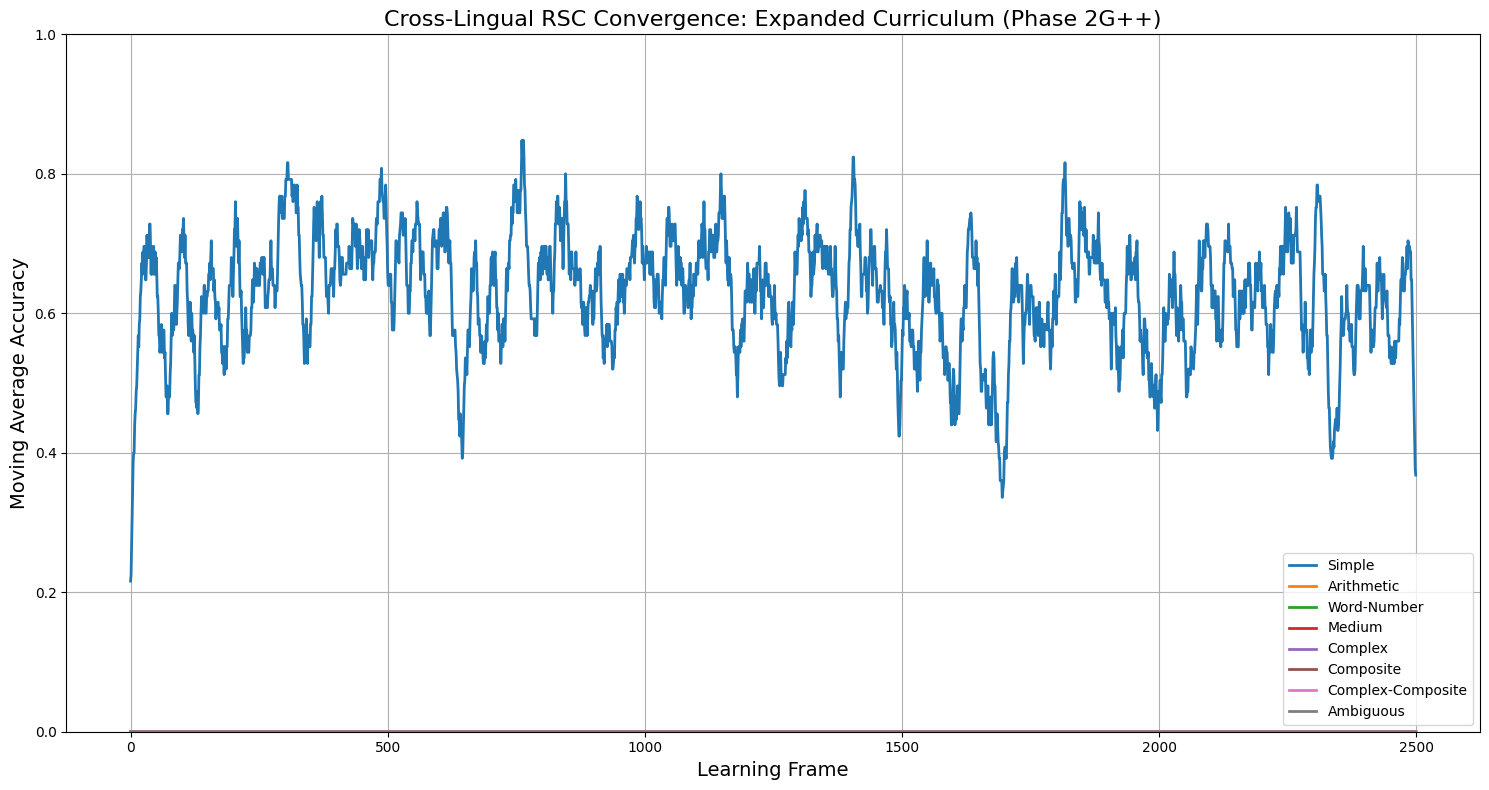

In [38]:
def main():
    # Load vocab and relations
    (english_vocab, german_vocab, eng_to_ger,
     simple_relations, word_number_relations, arithmetic_relations,
     medium_relations, complex_relations, composite_relations,
     complex_composite_relations, ambiguous_relations, narrative_relations) = load_vocab_and_relations()

    # Initialize Agents A, B, C
    agent_a, agent_b, agent_c = initialize_agents(english_vocab, german_vocab, eng_to_ger)

    # Run Learning Phase
    (proposals_log,
     accuracy_simple, accuracy_word_number, accuracy_arithmetic,
     accuracy_medium, accuracy_complex, accuracy_composite,
     accuracy_complex_composite, accuracy_ambiguous) = run_learning(
         agent_a, agent_b, agent_c,
         simple_relations, word_number_relations, medium_relations,
         complex_relations, composite_relations, complex_composite_relations,
         ambiguous_relations, arithmetic_relations,
         total_frames=2500)

    # Save learning logs
    with open('phase2G_learning_log.txt', 'w', encoding='utf-8') as f:
        for line in proposals_log:
            f.write(line + '\n')

    # Plot convergence results
    plot_accuracies(accuracy_simple, accuracy_word_number, accuracy_arithmetic,
                    accuracy_medium, accuracy_complex, accuracy_composite, accuracy_complex_composite,
                    accuracy_ambiguous,
                    total_frames=2500)

if __name__ == "__main__":
    main()